In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
gpu=tf.config.experimental.list_physical_devices('GPU')
for i in gpu:
    tf.config.experimental.set_memory_growth(i, True)

# 循环神经网络的高级用法

循环dropout：这是一种特殊的内置方法，在循环层中使用dropout来降低过拟合。

堆叠循环层：这会提高网络的表示能力。

双向循环层：将相同的信息以不同的方式呈现给循环网络，可以提高精度并缓解遗忘问题。

# 温度预测问题
到目前为止，我们讨论的唯一序列数据是文本数据，例如IMDB数据集和路透社数据集。但是序列数据不仅仅存在于语言处理的问题中。在本节的所有示例中，我们将使用德国耶拿马克斯 普朗克生物地球化学研究所气象站记录的气象时态数据集：http://www.bgc-jena.mpg.de/wetter/.

在这个数据集中，有14个不同的量(如气温、气压、湿度、风向等)。每十分钟记录一次。原始数据可以追溯到2003年，但我们仅使用2009-2016年的数据。此数据集非常适合学习如何使用时间序列。我们将使用它建立一个模型，以最近的一些数据(几天的数据点)作为输入，并预测未来24小时的气温。


In [3]:
# 6-28观察天气数据集的数据
import os

fname = r'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
# 6-29解析数据
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

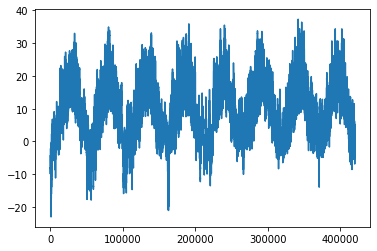

In [6]:
# 6-30绘制温度时间序列
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

# 
在这幅图上，你可以清楚地看到每年气温的周期性。

下面是温度数据前十天的一个更窄的图(因为数据每十分钟记录一次，我们每天得到144个数据点)：

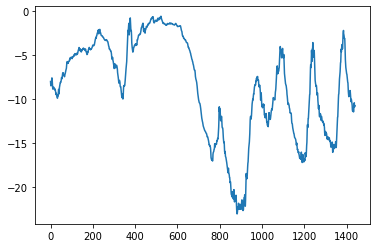

In [7]:
# 6-31绘制前10天的温度时间序列
plt.plot(range(1440), temp[:1440])
plt.show()

# 准备数据

我们将使用以下参数值：

lookback = 720，即我们的观察将追溯到5天前。

steps = 6，观察数据的采样频率是每小时一个数据点。

delay = 144，我们的目标是未来24小时之后的数据。

将每个时间序列减去其平均值，然后除以其标准差。

In [8]:
# 6-32数据标准化
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# 
数据生成器。它产生一个元组(samples, targets)其中samples是输入数据的一个批量，targets是对应的目标温度数组。

data：：原始数组

lookback：：我们的输入数据应该返回多少个时间步。

delay：：未来我们的目标应该是多少个时间步。

min_index和max_index：：data数组中索引

shuffle：：打乱样本

batch_size ：：每个批量样本数

step：：数据采样的周期，我们设为6，每小时抽取一个数据点

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
# 6-34准备训练生成器，验证生成器，测试生成器
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


val_steps = (300000 - 200001 - lookback) // batch_size


test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 一种基本的机器学习方法


In [11]:
# 6-37 训练并评估一个密集连接模型
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 15s 30ms/step - loss: 1.3064 - val_loss: 0.8167
Epoch 2/20
500/500 [==============================] - 15s 29ms/step - loss: 0.4404 - val_loss: 0.3914
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2971 - val_loss: 0.3493
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2695 - val_loss: 0.3230
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2544 - val_loss: 0.3191
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2458 - val_loss: 0.3113
Epoch 7/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2369 - val_loss: 0.3235
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2312 - val_loss: 0.3092
Epoch 9/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2266 - val_loss: 0.3139s
Epoch 10/20
500/500 [==============================] - 15s 30ms/step - loss: 0.22

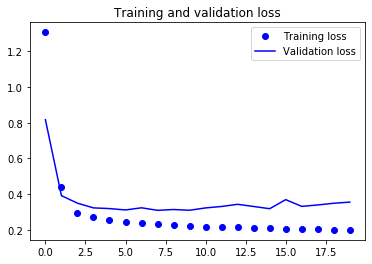

In [12]:
# 6-38绘制结果
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 第一个循环网络基准


In [13]:
# 6-39 训练并评估一个基于GRU的模型
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 30s 61ms/step - loss: 0.3027 - val_loss: 0.2719
Epoch 2/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2858 - val_loss: 0.2651
Epoch 3/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2771 - val_loss: 0.2636ETA: 3s - loss:  - 
Epoch 4/20
500/500 [==============================] - 27s 55ms/step - loss: 0.2720 - val_loss: 0.2647
Epoch 5/20
500/500 [==============================] - 28s 57ms/step - loss: 0.2670 - val_loss: 0.2692: 3s - loss: 0.26 -  - ETA: 2s - l - ETA: 1s - loss: 0.267
Epoch 6/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2625 - val_loss: 0.2723
Epoch 7/20
500/500 [==============================] - 30s 60ms/step - loss: 0.2568 - val_loss: 0.2653
Epoch 8/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2522 - val_loss: 0.2675
Epoch 9/20
500/500 [==============================] - 29s 57ms/step - loss: 0.2488 - val_loss: 0.2746- ETA:

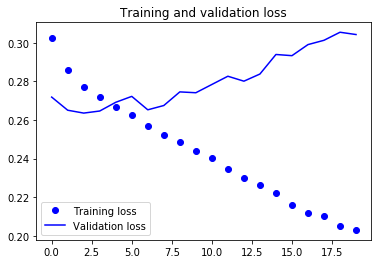

In [14]:
# 绘制结果
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 使用 循环dropout 来降低过拟合
在循环层前面使用dropout，这种正则化会妨碍学习过程，循环网络中应使用 循环dropout ：对每个时间步应该使用相同的dropout掩码，而不是让dropout掩码随着时间步的增加而随机变化。

In [ ]:
# 6-40训练并评估一个使用dropout的基于GRU的模型
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

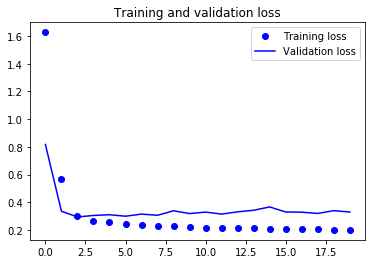

In [26]:
# 绘制结果
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 循环层堆叠
模型没有过拟合，但遇到了性能瓶颈，我们应该考虑增加网络容量。增加网络容量直到过拟合变成主要的障碍。增加网络容量的通常做饭时增加每层单元数或增加层数。

In [ ]:
# 6-41训练并评估模型
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

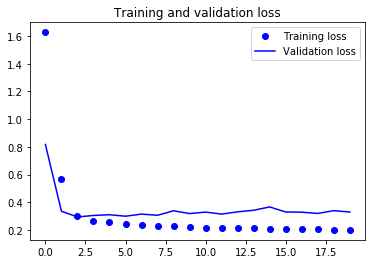

In [28]:
# 绘制结果
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 使用双向RNN

RNN特别依赖于顺序或时间，RNN按顺序处理输入序列的时间步，而打乱时间步或反转时间步会完全改变RNN从序列中提取的表示。因此，如果顺序对问题很重要，RNN的表现会很好。双向RNN利用了对顺序的敏感性：它包含两个普通RNN，每个RNN分别沿一个方向对输入序列进行处理，然后将他们合并在一起。通过沿这两个方向处理序列，双向RNN能够捕捉到可能被单向RNN忽略的模式。

In [29]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

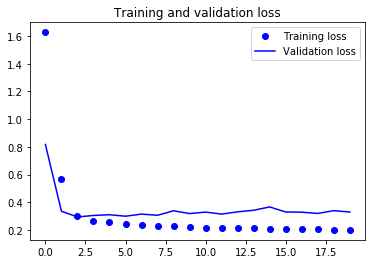

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# 6-42使用你序列训练并评估一个LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


max_features = 10000

maxlen = 500

# 加载数据
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 将序列反转
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 填充序列
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 17s 861us/sample - loss: 0.4768 - acc: 0.7739 - val_loss: 0.4207 - val_acc: 0.8308
Epoch 2/10
20000/20000 [==============================] - 10s 503us/sample - loss: 0.3129 - acc: 0.8799 - val_loss: 0.3504 - val_acc: 0.8800
Epoch 3/10
20000/20000 [==============================] - 10s 484us/sample - loss: 0.2527 - acc: 0.9076 - val_loss: 0.3281 - val_acc: 0.8734
Epoch 4/10
20000/20000 [==============================] - 10s 488us/sample - loss: 0.2165 - acc: 0.9212 - val_loss: 0.3760 - val_acc: 0.8440
Epoch 5/10
20000/20000 [==============================] - 10s 486us/sample - loss: 0.1884 - acc: 0.9323 - val_loss: 0.4877 - val_acc: 0.7954
Epoch 6/10
20000/20000 [==============================] - 10s 486us/sample - loss: 0.1687 - acc: 0.9402 - val_loss: 0.3835 - val_acc: 0.8514
Epoch 7/10
20000/20000 [==============================] - 10s 487us/sample - loss: 0.1487 - acc: 0.9475 -

# 
要将一个双向RNN实例化，我们需要使用Bidirectional层，它的第一个参数是一个循环层实例。

In [17]:
# 6-43训练并评估一个双向LSTM
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 13s 649us/sample - loss: 0.5520 - acc: 0.7154 - val_loss: 0.4206 - val_acc: 0.8362
Epoch 2/10
20000/20000 [==============================] - 10s 476us/sample - loss: 0.3320 - acc: 0.8709 - val_loss: 0.4155 - val_acc: 0.8154
Epoch 3/10
20000/20000 [==============================] - 10s 478us/sample - loss: 0.2566 - acc: 0.9058 - val_loss: 0.3613 - val_acc: 0.8678
Epoch 4/10
20000/20000 [==============================] - 10s 480us/sample - loss: 0.2303 - acc: 0.9168 - val_loss: 0.3289 - val_acc: 0.8842
Epoch 5/10
20000/20000 [==============================] - 10s 478us/sample - loss: 0.2038 - acc: 0.9280 - val_loss: 0.4646 - val_acc: 0.8580
Epoch 6/10
20000/20000 [==============================] - 10s 480us/sample - loss: 0.1780 - acc: 0.9381 - val_loss: 0.3117 - val_acc: 0.8790
Epoch 7/10
20000/20000 [==============================] - 10s 483us/sample - loss: 0.1611 - acc: 0.9436 -

# 
它的性能略好于我们在上一节中尝试过的常规LSTM，达到88%以上的验证精度。它似乎也适应得更快，这也就不足为奇了，因为双向层比按时间顺序排列的LSTM有两倍多的参数。有了一些正则化，双向方法很可能是这项任务的有力执行者。

现在，让我们尝试使用同样的方法来完成天气预报任务：

In [18]:
# 6-44训练并评估一个双向GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 44s 88ms/step - loss: 0.2963 - val_loss: 0.2697
Epoch 2/40
500/500 [==============================] - 43s 86ms/step - loss: 0.2720 - val_loss: 0.2637
Epoch 3/40
500/500 [==============================] - 44s 88ms/step - loss: 0.2670 - val_loss: 0.2670
Epoch 4/40
500/500 [==============================] - 44s 88ms/step - loss: 0.2623 - val_loss: 0.2638
Epoch 5/40
500/500 [==============================] - 43s 86ms/step - loss: 0.2578 - val_loss: 0.2692
Epoch 6/40
500/500 [==============================] - 43s 87ms/step - loss: 0.2548 - val_loss: 0.2676
Epoch 7/40
500/500 [==============================] - 46s 92ms/step - loss: 0.2485 - val_loss: 0.2705
Epoch 8/40
500/500 [==============================] - 47s 94ms/step - loss: 0.2425 - val_loss: 0.2748
Epoch 9/40
500/500 [==============================] - 44s 88ms/step - loss: 0.2373 - val_loss: 0.2852
Epoch 10/40
500/500 [==============================] - 45s 89ms/step - loss: 0.230